In [1]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44811 instead
  warnings.warn(


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os
import gcm_filters
import xrft
from dask.diagnostics import ProgressBar
from rechunker import rechunk
import zarr

In [2]:
eta_merged = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_long.zarr')
eta_merged = eta_merged.isel(time=slice(1,1800))

In [3]:
eta_28 = eta_merged.isel(time=slice(0,2000,3))

In [4]:
#write to zarr so we can rechunk into time
eta_28.to_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_28.zarr')

In [9]:
eta_28

<xarray.Dataset>
Dimensions:  (i: 2160, j: 2160, time: 584)
Coordinates:
  * i        (i) int64 1080 1081 1082 1083 1084 ... 3235 3236 3237 3238 3239
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * j        (j) float64 0.0 1.0 2.0 3.0 ... 2.157e+03 2.158e+03 2.159e+03
  * time     (time) timedelta64[ns] 3 days 00:00:00 ... 75 days 21:00:00
    x        (j, i) float32 dask.array<chunksize=(270, 540), meta=np.ndarray>
    y        (j, i) float32 dask.array<chunksize=(270, 540), meta=np.ndarray>
Data variables:
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 270, 540), meta=np.ndarray>

# Rechunk in time so that tide fitting is easier

In [5]:
source = zarr.open('/swot/SUM02/spencer/swot_agulhas_surf/eta_28.zarr')
intermediate = "/swot/SUM02/spencer/swot_agulhas_surf/intermediate.zarr"
target = "/swot/SUM02/spencer/swot_agulhas_surf/eta_28time.zarr"

In [11]:
target_chunks = {
    'Eta': {'time':584,'j':180,'i':180},
    'x': {'i':180, 'j':180},
    'y': {'i':180, 'j':180},
    'time': None, # don't rechunk this array
    'iter': None,
    'i': None,
    'j': None,
}

In [12]:
rechunked = rechunk(source, target_chunks=target_chunks,target_store=target,max_mem='800MB',temp_store=intermediate)

In [13]:
rechunked.execute();

_copy_chunk((slice(0, 411, None), slice(0, 270, None), slice(0, 1800, None)))
_copy_chunk((slice(0, 411, None), slice(0, 270, None), slice(1800, 2160, None)))
_copy_chunk((slice(0, 411, None), slice(270, 540, None), slice(0, 1800, None)))
_copy_chunk((slice(0, 411, None), slice(270, 540, None), slice(1800, 2160, None)))
_copy_chunk((slice(0, 411, None), slice(540, 810, None), slice(0, 1800, None)))
_copy_chunk((slice(0, 411, None), slice(540, 810, None), slice(1800, 2160, None)))
_copy_chunk((slice(0, 411, None), slice(810, 1080, None), slice(0, 1800, None)))
_copy_chunk((slice(0, 411, None), slice(810, 1080, None), slice(1800, 2160, None)))
_copy_chunk((slice(0, 411, None), slice(1080, 1350, None), slice(0, 1800, None)))
_copy_chunk((slice(0, 411, None), slice(1080, 1350, None), slice(1800, 2160, None)))
_copy_chunk((slice(0, 411, None), slice(1350, 1620, None), slice(0, 1800, None)))
_copy_chunk((slice(0, 411, None), slice(1350, 1620, None), slice(1800, 2160, None)))
_copy_chunk((sli

In [14]:
eta_timechunks = xr.open_zarr("/swot/SUM02/spencer/swot_agulhas_surf/eta_28time.zarr")
eta_detrend = eta_28.Eta.drop_vars('time') - eta_28.Eta.rolling(time=18).mean().drop_vars('time')
eta_detrend.to_dataset(name='Eta').to_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_28detrend.zarr')

# Start here to restart

In [3]:
eta_detrend = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_28detrend.zarr').Eta

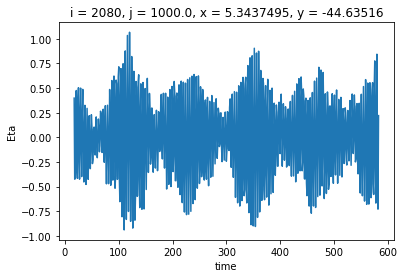

In [16]:
eta_detrend.isel(i=1000,j=1000).plot()

In [4]:
m2=12.42/3
s2=12/3
n2=12.66/3
k2=11.97/3
k1=23.93/3
o1=25.82/3
q1=26.88/3
p1=24.066/3
#o1 is still really hard to fit in many locations. p1 too and it's very small

def sinusoid_check(time, a=0.004,b=0.5,c=1.3,d=0.1,e=4,f=0.1,g=0.1,l=0.1,m=0.1,n=0.1,o=0.1,p=0.1,q=0.1):#,h=0.1,k=0.1,r=0.1,s=0.1):
    return (a+b*np.sin(time*2*np.pi/m2+c)+d*np.sin(time*2*np.pi/s2+e)+f*np.sin(time*2*np.pi/k1+g)+
        l*np.sin(time*2*np.pi/n2+m)+n*np.sin(time*2*np.pi/k2+o)+p*np.sin(time*2*np.pi/q1+q))#h*np.sin(time*2*np.pi/o1+k)++r*np.sin(time*2*np.pi/p1+s))

In [30]:
check_it = (eta_detrend).chunk({'time': -1}).isel(i=slice(500,1000),j=1000,time=slice(18,2000)).curvefit('time',sinusoid_check,skipna=False,
                                                                              bounds={"b": (0, 2),"c": (0, 2*np.pi),"d": (0, 2),"e": (0, 2*np.pi),"f": (0, 1),"g": (0, 2*np.pi),"h": (0, 1),"k": (0, 2*np.pi),"l": (0, 1),"m": (0, 2*np.pi),"n": (0, 1),"o": (0, 2*np.pi),"p": (0, 1),"q": (0, 2*np.pi),"r": (0, 1),"s": (0, 2*np.pi)})


In [ ]:
for ii in range(0,216):
    print(ii)
    test_curvefit = eta_detrend.chunk({'time':-1}).isel(i=slice(ii*10,ii*10+10),time=slice(18,-18)).curvefit('time',sinusoid_check,skipna=False,
                                                                              bounds={"b": (0, 2),"c": (0, 2*np.pi),"d": (0, 2),"e": (0, 2*np.pi),"f": (0, 1),"g": (0, 2*np.pi),"l": (0, 1),"m": (0, 2*np.pi),"n": (0, 1),"o": (0, 2*np.pi),"p": (0, 1),"q": (0, 2*np.pi)})#,"h": (0, 1),"k": (0, 2*np.pi)
    test_curvefit.curvefit_coefficients.to_dataset().to_zarr('/swot/SUM02/spencer/swot_agulhas_surf/curvefit_28.zarr',append_dim='i')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [18]:
coeffs = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/curvefit_28.zarr').isel(i=slice(10,2170))

In [19]:
coeffs

<xarray.Dataset>
Dimensions:                (i: 870, j: 2160, param: 15)
Coordinates:
  * i                      (i) int64 1080 1081 1082 1083 ... 1946 1947 1948 1949
  * j                      (j) float64 0.0 1.0 2.0 ... 2.158e+03 2.159e+03
  * param                  (param) <U1 'a' 'b' 'c' 'd' 'e' ... 'n' 'o' 'p' 'q'
    x                      (j, i) float32 dask.array<chunksize=(270, 530), meta=np.ndarray>
    y                      (j, i) float32 dask.array<chunksize=(270, 530), meta=np.ndarray>
Data variables:
    curvefit_coefficients  (j, i, param) float64 dask.array<chunksize=(270, 10, 15), meta=np.ndarray>

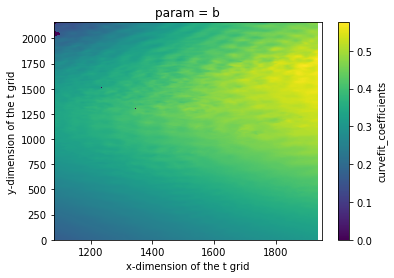

In [21]:
coeffs.curvefit_coefficients.sel(param='b').plot()

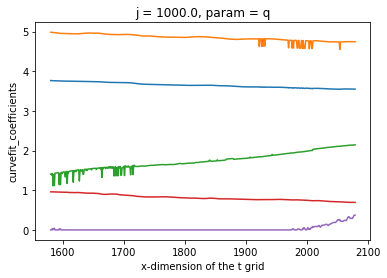

In [31]:
check_it.curvefit_coefficients.sel(param='c').plot()
check_it.curvefit_coefficients.sel(param='e').plot()
check_it.curvefit_coefficients.sel(param='g').plot()
#check_it.curvefit_coefficients.sel(param='k').plot()
check_it.curvefit_coefficients.sel(param='m').plot()
#check_it.curvefit_coefficients.sel(param='o').plot()
check_it.curvefit_coefficients.sel(param='q').plot()
#check_it.curvefit_coefficients.sel(param='s').plot()

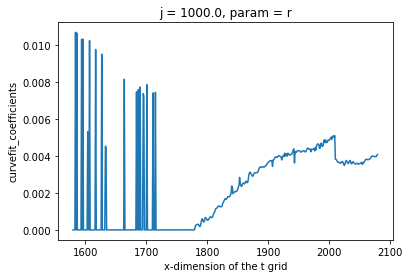

In [35]:
check_it.curvefit_coefficients.sel(param='r').plot()

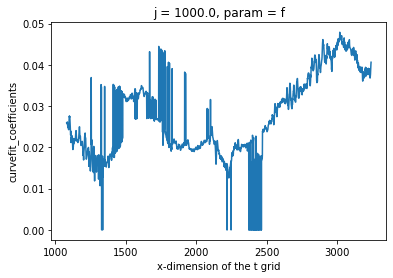

In [89]:
check_it.curvefit_coefficients.sel(param='o').plot()

In [107]:
new_object=xr.DataArray(np.arange(0, 224),dims=['time'])
new_object = new_object*xr.ones_like(eta_detrend)

In [108]:
tide_est = xr.apply_ufunc(sinusoid_check,new_object,check_it.curvefit_coefficients.sel(param='a'),check_it.curvefit_coefficients.sel(param='b'),
              check_it.curvefit_coefficients.sel(param='c'),check_it.curvefit_coefficients.sel(param='d'),
              check_it.curvefit_coefficients.sel(param='e'),check_it.curvefit_coefficients.sel(param='f'),
              check_it.curvefit_coefficients.sel(param='g'),check_it.curvefit_coefficients.sel(param='h'),
              check_it.curvefit_coefficients.sel(param='k'),check_it.curvefit_coefficients.sel(param='l'),
              check_it.curvefit_coefficients.sel(param='m'),check_it.curvefit_coefficients.sel(param='n'),
                        check_it.curvefit_coefficients.sel(param='o'),check_it.curvefit_coefficients.sel(param='p'),
                        check_it.curvefit_coefficients.sel(param='q'),check_it.curvefit_coefficients.sel(param='r'),
                        check_it.curvefit_coefficients.sel(param='s')
            ,dask='allowed')

In [110]:
eta_detrend.isel(i=1000,j=1000,time=slice(18,1000)).plot()
(eta_detrend.isel(i=1000,j=1000,time=slice(18,1000))-tide_est.isel(time=slice(0,-18))).plot()
tide_est.isel(time=slice(0,1000)).plot()

KeyboardInterrupt: 

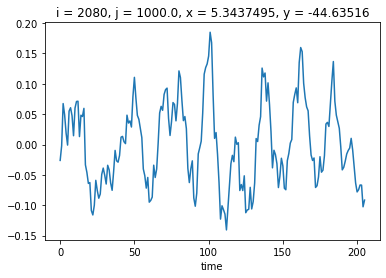

In [100]:
(eta_detrend.isel(i=1000,j=1000,time=slice(18,1000))-tide_est.isel(time=slice(0,-18))).plot()